# Event sort

This page discusses the details of the using and implementing the event sorting approach.

In [54]:
from typing import Callable
from datetime import datetime
from matplotlib import pyplot as plt

## Example

Consider series of periods visualised on the following picture.

<svg width=700 height=200 stroke="black" stroke-width="3"
    style="font-family: 'LatinModern'" font-style="italic" font-size=30>
  <line x1=0 y1=150 x2=605 y2=150 />
    <line x1=605 y1=150 x2=574.75 y2=160 />
    <line x1=605 y1=150 x2=574.75 y2=140 />
  <g stroke-width="2">
    <line x1=30 y1=130 x2=300 y2=130 />
    <line x1=100 y1=110 x2=240 y2=110 />
    <line x1=180 y1=90 x2=360 y2=90 />
    <line x1=360 y1=130 x2=550 y2=130 />
    <g stroke-dasharray="4">
    <line x1=30 y1=130 x2=30 y2=150 />
      <line x1=300 y1=130 x2=300 y2=150 />
      <line x1=100 y1=110 x2=100 y2=150 />
      <line x1=240 y1=110 x2=240 y2=150 />
      <line x1=180 y1=90 x2=180 y2=150 />
      <line x1=360 y1=90 x2=360 y2=150 />
      <line x1=360 y1=130 x2=360 y2=150 />
      <line x1=550 y1=130 x2=550 y2=150 />
    </g>
  </g>
  <circle cx=30 cy=130 r=2 />
  <circle cx=300 cy=130 r=2 />
  <circle cx=100 cy=110 r=2 />
  <circle cx=240 cy=110 r=2 />
  <circle cx=180 cy=90 r=2 />
  <circle cx=360 cy=90 r=2 />
  <circle cx=360 cy=130 r=2 />
  <circle cx=550 cy=130 r=2 />
  <g stroke-width=0 text-anchor="middle">
    <text x=580 y=180>t</text>
    <text x=100 y=180>100</text>
    <text x=550 y=180>550</text>
    <text x=360 y=180>360</text>
    <text x=300 y=180>300</text>
    <text x=240 y=180>240</text>
    <text x=180 y=180>180</text>
    <text x=30 y=180>30</text>
  </g>
</svg>


Suppose you need to identify the time interval with the most simultaneous processes. The event-sort approach is a special solution this type of tasks.

---

The following cell shows the program's implementation and prints its output.

In [1]:
START, END = 0, 1
intervals = [(30, 300), (100, 240), (180, 360), (360, 550)]

events: list[tuple[int, int]] = []
for start, end in intervals:
    events.append((start, START))
    events.append((end, END))

events.sort()

max_count = 0
best_interval = (0, 0)
active_intervals = 0
for i, (e_moment, e_type) in enumerate(events):
    if (active_intervals > max_count) and (i != 0):
        max_count = active_intervals
        best_interval = (events[i - 1][0], e_moment)

    if e_type == START:
        active_intervals += 1
    else:  # e_type == END
        active_intervals -= 1


print(best_interval)

(180, 240)


## Two passes

There are some tasks for which the event-sorting approach can lead to quadratic complexity. These are tasks that require returning a set of objects corresponding to a specific state - so at each step, the conditions are checked and the current set is copied to the result set. In the worst case, the result set may need to be updated at every event, which results in quadratic complexity with respect to the number of events.

There are several approaches that can be used in specific cases, but the most universal solution is to go through the events twice: first, to determine the positions where the conditions are met, and second, to find the appropriate result based on those positions.

---

Consider the following task: given a set of time periods $(t_i, t'_i)$, find the set of indices of the periods that fall within the time interval where the maximum number of periods overlap.

In [13]:
START, END = 0, 1

def construct_events(intervals: list[tuple[int, int]]) -> list[tuple[int, int, int]]:
    events: list[tuple[int, int, int]] = []
    for i, (start, end) in enumerate(intervals):
        events.append((start, START, i))
        events.append((end, END, i))
    return events

In [ ]:
def basic_solution(intervals: list[tuple[int, int]]) -> set[int]:
    events = construct_events(intervals)
    events.sort()

    intervals_set: set[int] = set()
    ans: set[int] = set()

    for _, e_type, i in events:
        if e_type == START:
            intervals_set.add(i)
        else:  # e_type == END
            intervals_set.remove(i)
        if len(intervals_set) > len(ans):
            ans = intervals_set.copy() # Notice that we copy the set here
    return ans

In [16]:
basic_solution([(30, 50), (100, 240), (180, 360), (360, 550)])

{1, 2}

In [38]:
def generate_case(n: int) -> list[tuple[int, int]]:
    return [(i, n + i)for i in range(n)]

In [62]:
def estimate_time_complexity(target: Callable[[list[tuple[int, int]]], set[int]]) -> list[tuple[int, float]]: 
    timings: list[tuple[int, float]] = []
    for i in range(1, 2_000):
        res: list[float] = []
        for _ in range(5):
            start = datetime.now()
            target(generate_case(i))
            end = datetime.now()
            res.append((end - start).total_seconds())
        timings.append((i, sum(res)/len(res)))
    return timings

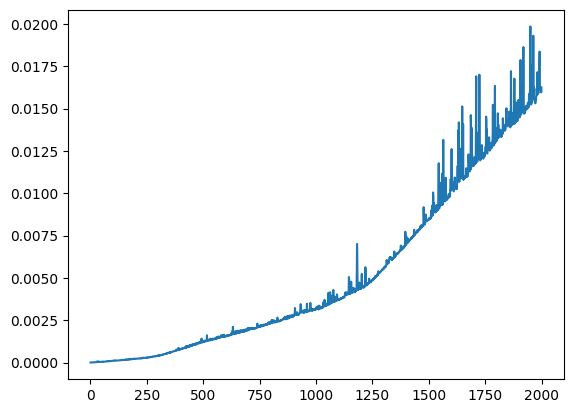

In [ ]:
timings_basic = estimate_time_complexity(basic_solution)
plt.plot([x for x, _ in timings_basic], [y for _, y in timings_basic])

In [64]:
def two_pass(intervals: list[tuple[int, int]]) -> set[int]:
    events = construct_events(intervals)
    events.sort()

    intervals_set: set[int] = set()

    count = 0
    max_count = 0
    for _, e_type, _ in events:
        if e_type == START:
            count += 1
        else:  # e_type == END
            count -= 1
        max_count = max(max_count, count)

    for _, e_type, i in events:
        if e_type == START:
            intervals_set.add(i)
        else:  # e_type == END
            intervals_set.remove(i)
        if len(intervals_set) == max_count:
            return intervals_set
    return set()

In [65]:
timings_two_passes = estimate_time_complexity(two_pass)

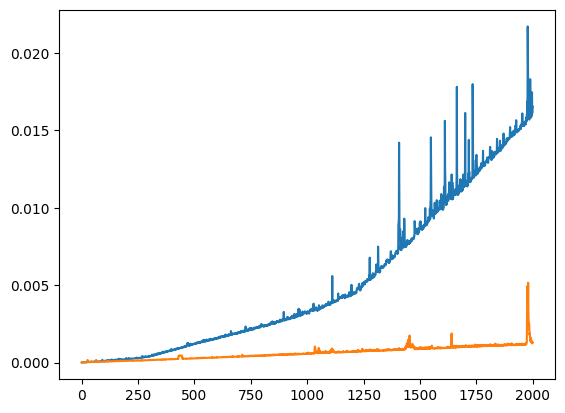

In [67]:
plt.plot([x for x, _ in timings_basic], [y for _, y in timings_basic])
plt.plot([x for x, _ in timings_two_passes], [y for _, y in timings_two_passes])